In [1]:
from modules.models import HeatPinn, create_dense_model
from modules.data import simulate_heat
from modules.plots import plot_heat_model, plot_training_loss
import tensorflow as tf
import numpy as np

2022-12-31 03:14:49.946789: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
#https://personal.math.ubc.ca/~peirce/HeatProblems.pdf

k = 1.0
x_start = 0
length = 2 * np.pi

def phi_function(tx):
    return 3.0 * tf.sin(5 * tx[:, 1:] / 2) 

def boundary_function(tx):
    return tf.zeros_like(tx[:, 1:])


def u_exact(tx):
    return 3 * tf.sin(5 * tx[:, 1:] / 2) * tf.exp(-(5 / 2)**2 * tx[:, :1])

In [3]:
(tx_samples, y_res), (tx_init, u_init), (tx_bnd, u_bnd) = simulate_heat(2000, phi_function, boundary_function, length=length, time=1, random_seed=42, dtype=tf.float32)

2022-12-31 03:14:52.718828: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-31 03:14:52.765568: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-31 03:14:52.765878: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-31 03:14:52.766786: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropri

In [4]:
inputs = [tx_samples, tx_init, tx_bnd]
outputs = [u_exact(tx_samples), y_res, u_init, u_bnd]

In [5]:
backbone = create_dense_model([64, 64, 64], activation='tanh', initializer='glorot_normal', \
    n_inputs=2, n_outputs=1)

In [6]:
pinn = HeatPinn(backbone, k=k)
scheduler = tf.keras.optimizers.schedules.ExponentialDecay(1e-3, decay_steps=500, decay_rate=0.92)
optimizer = tf.keras.optimizers.Adam(learning_rate=scheduler)
pinn.compile(optimizer=optimizer)

In [7]:
history = pinn.fit(inputs, outputs, epochs=20000, batch_size=500, verbose=0)

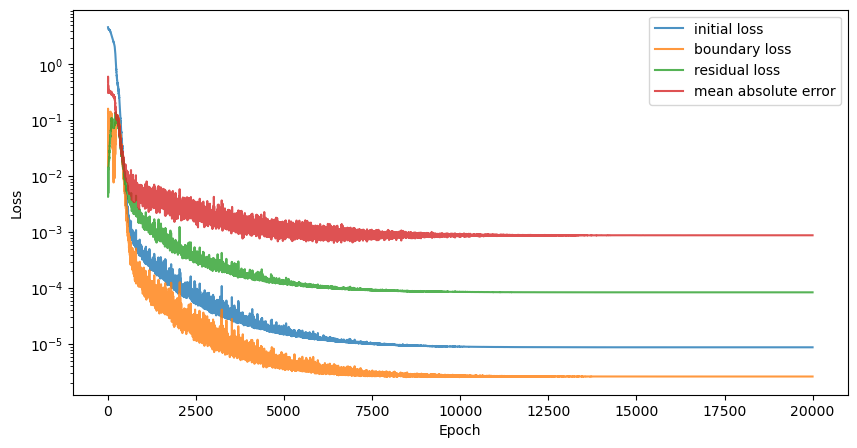

In [8]:
plot_training_loss(history.history, y_scale='log')

1/1 [==============================] - 0s 25ms/step


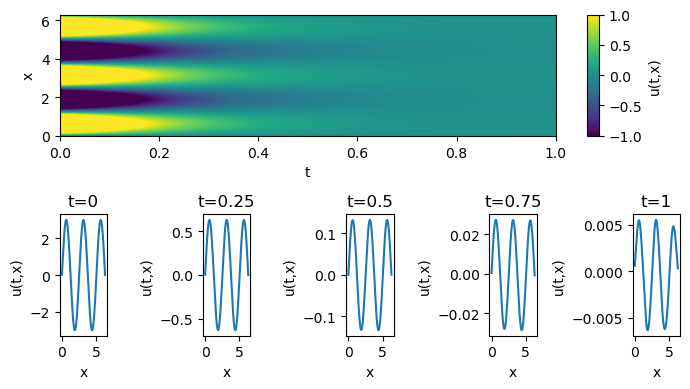

In [9]:
plot_heat_model(pinn.backbone, length, 1)